PCI: 165
Clutter Loss statistics (in dBm): Min: 25.09, Max: 69.41, Mean: 51.11, Std Dev: 8.65


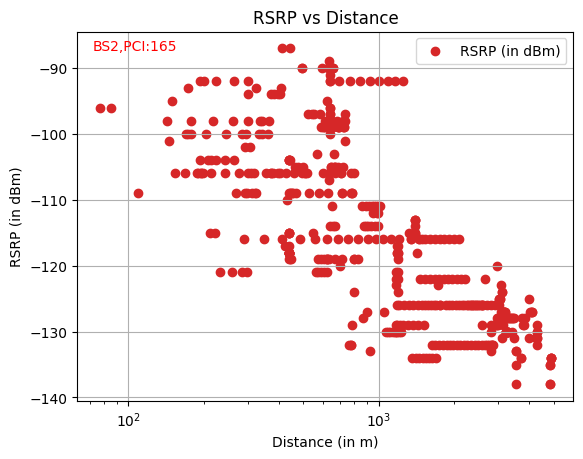

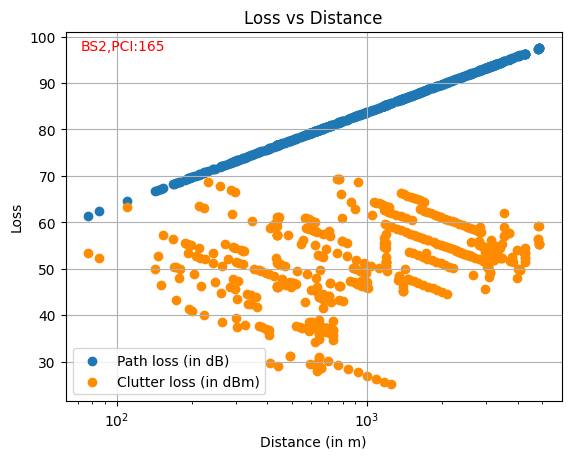

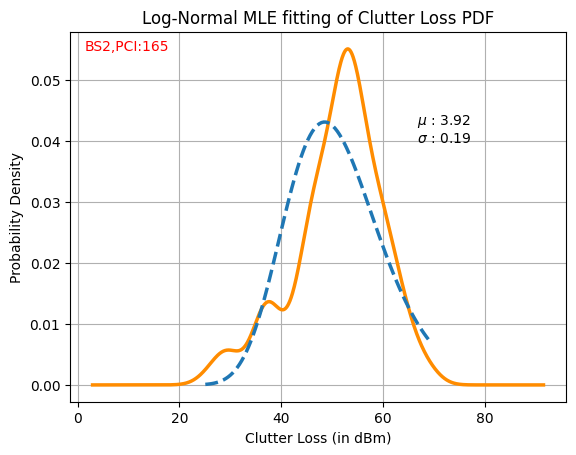

In [2]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
import sys

fix_pci = 165
# fix_pci = int(input('Enter PCI: '))
print(f"PCI: {fix_pci}")
match fix_pci:
    case 14 | 88:
        fix_freq = 3560e6
    case 189 | 1 | 96 | 26 | 187:
        fix_freq = 3580e6
    case 195 | 46:
        fix_freq = 3600e6
    case 6 | 150 | 10 | 200 | 165:
        fix_freq = 3670e6
    case 169 | 194 | 78 | 69:
        fix_freq = 3690e6
    case _:
        sys.exit()

match fix_pci: # https://www.fcc.gov/media/radio/dms-decimal
    case 189 | 195 | 6 | 150 | 169 | 194:
        # https://maps.app.goo.gl/5WMfETE9VkzZQvBx8
        bs_name = 'BS1'
        bs_lat = 41.65425
        bs_lon = -86.24375
        bs_height = 45
    case 1 | 10 | 200 | 165 | 78 | 69:
        # https://maps.app.goo.gl/HDvgbdpteGhEeBAk8
        bs_name = 'BS2'
        bs_lat = 41.663278
        bs_lon = -86.254139
        bs_height = 55
    case 14 | 88 | 96 | 26:
        # https://maps.app.goo.gl/GyG1Y2veuAiZMfw38
        bs_name = 'BS3'
        bs_lat = 41.67225
        bs_lon = -86.292778
        bs_height = 33
    case 187 | 46:
        # https://maps.app.goo.gl/nazumHiRpfgrL5kV8
        bs_name = 'BS4'
        bs_lat = 41.668678
        bs_lon = -86.312222
        bs_height = 13
    case _:
        sys.exit()

csv_files = glob.glob('data/sigcap_data/*.csv')
filtered_dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    filtered_df = df[df['pci'] == fix_pci]
    filtered_df = filtered_df[['latitude', 'longitude', 'altitude', 'pci', 'rsrp']]
    filtered_df['file_name'] = file
    filtered_dfs.append(filtered_df)
df_fix_pci = pd.concat(filtered_dfs)

del filtered_dfs, filtered_df, df, csv_files, file


def haversine(lat1, lon1, lat2, lon2, bs_height):
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371  # Radius of the Earth in kilometers
    distance_2d = c * r * 1e3
    distance_3d = np.sqrt(distance_2d**2 + bs_height**2)
    return distance_3d

df_fix_pci['distance'] = haversine(df_fix_pci['latitude'], df_fix_pci['longitude'], bs_lat, bs_lon, bs_height)
df_fix_pci['pl_calc'] = 20 * np.log10((4 * np.pi * df_fix_pci['distance']) * fix_freq / (3*10e8))
# df_fix_pci['calc_theta'] = np.rad2deg(np.arctan(bs_height / df_fix_pci['distance']))
# df_fix_pci['clutter_loss'] = 18.75 - df_fix_pci['pl_calc'] - df_fix_pci['rsrp']
df_fix_pci['clutter_loss'] = 18.75 - df_fix_pci['pl_calc'] - df_fix_pci['rsrp']

if fix_pci == 150:
    df_fix_pci = df_fix_pci[df_fix_pci['distance'] < 1e3]
if fix_pci == 189:
    df_fix_pci = df_fix_pci[df_fix_pci['distance'] < 2*1e3]
if fix_pci == 96:
    df_fix_pci = df_fix_pci[df_fix_pci['distance'] < 1e5]
if fix_pci == 46:
    df_fix_pci = df_fix_pci[df_fix_pci['distance'] < 1e5]
if fix_pci == 187:
    df_fix_pci = df_fix_pci[df_fix_pci['distance'] < 1e5]

# dist_min = df_fix_pci['distance'].min()
# dist_max = df_fix_pci['distance'].max()
# dist_mean = df_fix_pci['distance'].mean()
# dist_std_dev = df_fix_pci['distance'].std()

# theta_min = df_fix_pci['calc_theta'].min()
# theta_max = df_fix_pci['calc_theta'].max()
# theta_mean = df_fix_pci['calc_theta'].mean()
# theta_std_dev = df_fix_pci['calc_theta'].std()

clutter_loss_min = df_fix_pci['clutter_loss'].min()
clutter_loss_max = df_fix_pci['clutter_loss'].max()
clutter_loss_mean = df_fix_pci['clutter_loss'].mean()
clutter_loss_std_dev = df_fix_pci['clutter_loss'].std()
print(f"Clutter Loss statistics (in dBm): "
    f"Min: {clutter_loss_min:.2f}, Max: {clutter_loss_max:.2f}, "
    f"Mean: {clutter_loss_mean:.2f}, Std Dev: {clutter_loss_std_dev:.2f}")

plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance'], df_fix_pci['rsrp'], color='tab:red')
plt.legend(['RSRP (in dBm)'])
plt.xlabel('Distance (in m)')
plt.ylabel('RSRP (in dBm)')
plt.title('RSRP vs Distance')
plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
plt.grid()
plt.show()

plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance'], df_fix_pci['pl_calc'], color='tab:blue')
plt.scatter(df_fix_pci['distance'], df_fix_pci['clutter_loss'], color='darkorange')
plt.legend(['Path loss (in dB)', 'Clutter loss (in dBm)'], loc='lower left')
plt.xlabel('Distance (in m)')
plt.ylabel('Loss')
plt.title('Loss vs Distance')
# plt.xlim(10,10000)
# plt.ylim(40,130)
plt.text(0.03, 0.95, f"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
plt.grid()
plt.show()

# df_fix_pci['clutter_loss'].plot(kind='density', linewidth=2.5, color='darkorange')
# plt.xlabel('Clutter Loss (in dBm)')
# plt.ylabel('Probability Density')
# plt.title('PDF of Clutter Loss')
# plt.grid()
# plt.show()

# plt.ecdf(df_fix_pci['clutter_loss'], linewidth=2.5, color='darkorange')
# plt.xlabel('Clutter Loss (in dBm)')
# plt.ylabel('CDF')
# plt.title('CDF of Clutter Loss')
# plt.grid()
# plt.show()

df_fix_pci['clutter_loss'].plot(kind='density', color='darkorange', linewidth=2.5)
plt.xlabel('Clutter Loss (in dBm)')
plt.ylabel('Probability Density')
plt.title('Log-Normal MLE fitting of Clutter Loss PDF')
# Log-normal fitting: MLE: https://www.itl.nist.gov/div898/handbook/eda/section3/eda3669.htm
# parameters scale & shape as per given links definition
# parameters mu & sigma as per wikipedia definition
# scale = exp(mu) & shape = sigma
shape, loc, scale = stats.lognorm.fit(df_fix_pci['clutter_loss'], floc=0)
x_temp = np.linspace(df_fix_pci['clutter_loss'].min(), df_fix_pci['clutter_loss'].max(), 100)
plt.plot(x_temp, stats.lognorm.pdf(x_temp, shape, loc, scale),linestyle='dashed', linewidth=2.5)
plt.text(0.7, 0.7, rf"$\mu$ : {np.log(scale):.2f}""\n"rf"$\sigma$ : {shape:.2f}",\
    transform=plt.gca().transAxes)
plt.text(0.03, 0.95, rf"{bs_name},PCI:{fix_pci}", transform=plt.gca().transAxes, color='red')
# plt.xlim(10,160)
# plt.ylim(-0.01,0.07)
plt.grid()
plt.show()
del x_temp

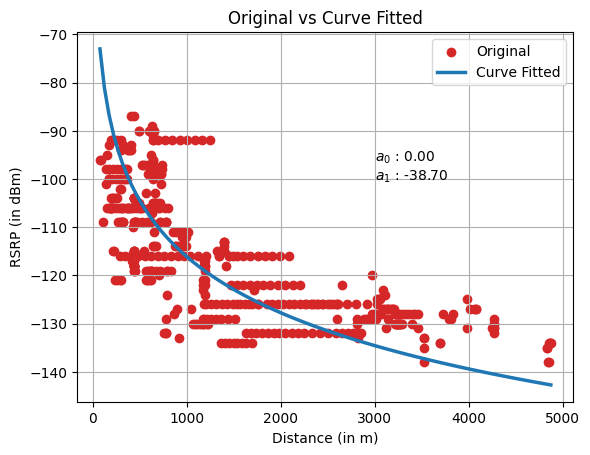

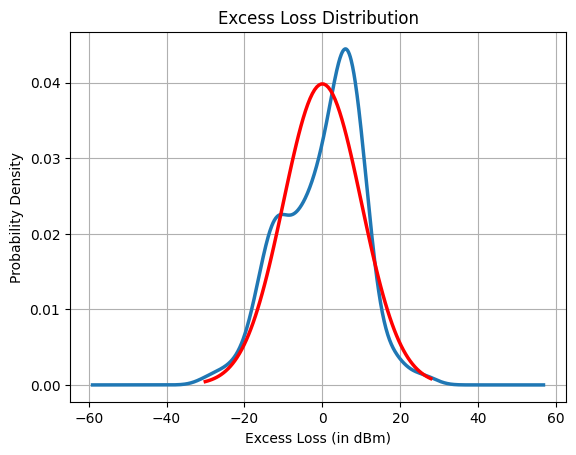

Mean: -0.00
Standard Deviation: 10.01


In [3]:
# from scipy.optimize import curve_fit

# def equation(distance, a, b):
#     return a + 10 * np.log10(distance)

# popt, pcov = curve_fit(equation, df_fix_pci['distance'], df_fix_pci['rsrp'], [-4, -105])
# a_optimized, b_optimized = popt
# print(f"Optimized value of a: {a_optimized}")
# print(f"Optimized value of b: {b_optimized}")


# plt.scatter(df_fix_pci['distance'], df_fix_pci['rsrp'], color='tab:red', label='Original')
# plt.plot(df_fix_pci['distance'], equation(df_fix_pci['distance'], a_optimized, b_optimized), color='tab:blue', label='Curve Fitted')
# plt.xlabel('Distance (in m)')
# plt.ylabel('RSRP (in dBm)')
# plt.title('Original vs Curve Fitted')
# plt.legend()
# plt.grid()
# plt.show()

# del a_optimized, b_optimized, popt, pcov, equation

y_mean = df_fix_pci['rsrp'].mean()
fx_mean = np.log10(df_fix_pci['distance']).mean()
y_fx_mean = (df_fix_pci['rsrp'] * np.log10(df_fix_pci['distance'])).mean()
fx2_mean = (np.log10(df_fix_pci['distance'])**2).mean()

a1 = (y_fx_mean - len(df_fix_pci)*fx_mean*y_mean) / (fx2_mean - len(df_fix_pci)*(fx_mean**2))
a0 = y_mean - a1*fx_mean

# plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance'], df_fix_pci['rsrp'], color='tab:red', label='Original')
x_temp = np.linspace(df_fix_pci['distance'].min(), df_fix_pci['distance'].max(), 100)
plt.plot(x_temp, a0 + a1*np.log10(x_temp), linewidth=2.5, color='tab:blue', label='Curve Fitted')
plt.text(0.6, 0.6, rf"$a_0$ : {a0:.2f}""\n"rf"$a_1$ : {a1:.2f}",\
    transform=plt.gca().transAxes)
plt.xlabel('Distance (in m)')
plt.ylabel('RSRP (in dBm)')
plt.title('Original vs Curve Fitted')
plt.legend()
plt.grid()
plt.show()

df_fix_pci['excess_loss'] = df_fix_pci['rsrp'] - (a0 + a1*np.log10(df_fix_pci['distance']))
df_fix_pci['excess_loss'].plot(kind='density', linewidth=2.5)
mu, sigma = stats.norm.fit(df_fix_pci['excess_loss'])
x_temp = np.linspace(df_fix_pci['excess_loss'].min(), df_fix_pci['excess_loss'].max(), 100)
pdf = stats.norm.pdf(x_temp, mu, sigma)
plt.plot(x_temp, pdf, 'r-', linewidth=2.5)
plt.xlabel('Excess Loss (in dBm)')
plt.ylabel('Probability Density')
plt.title('Excess Loss Distribution')
plt.grid()
plt.show()

print(f"Mean: {mu:.2f}")
print(f"Standard Deviation: {sigma:.2f}")

In [4]:
# Example data points
x_i = df_fix_pci['distance']
y_i = df_fix_pci['rsrp']
u_i = np.log(x_i)

n = len(x_i)
sum_u = np.sum(u_i)
sum_u2 = np.sum(u_i**2)
sum_y = np.sum(y_i)
sum_uy = np.sum(u_i * y_i)

A = np.array([[n, sum_u], [sum_u, sum_u2]])
b = np.array([sum_y, sum_uy])
a_0, a_1 = np.linalg.solve(A, b)

print("Estimated a_0:", a_0)
print("Estimated a_1:", a_1)

Estimated a_0: -41.293262615942616
Estimated a_1: -10.828613544205346
